In [ ]:
old:
60% normal (train)
20% - 70% is normal, 30% is sprites (val)
20% - 70% is normal, 30% is sprites (test)

new:


-calculate image ROC,PRC,DICE for each image rather than flatten as a entire batch
-make and test VAE
-repeat experiment 3x (once determined hyperparameters)


goals:
-rerun found VE Dense to new metrics
-rerun VE Dense with supervised
-create VAE, run with unsupervised
-run VAE with supervised

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading

from PIL import Image
import numpy as np
import json        
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, transforms
from time import time
import os
import tempfile
import torchvision
import gc
import optuna
from optuna.trial import TrialState
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    MaskIntensity,
    ThresholdIntensity
)
from monai.utils import set_determinism
from monai.transforms.utils import rescale_array
import PIL
import matplotlib.pyplot as plt
import math
import random

from custommodels import AutoEnc
from customfunctions import resetSeeds,splitData,loadMedNISTData,loadDSprites,\
    score,metrics,json_reformatter,MedNISTDataset,storeResults,memDebugger,train,objective

import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})

c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
resetSeeds() #helps when rerunning cells

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Created temp directory {root_dir}.")

Created temp directory C:\Users\irose\AppData\Local\Temp\tmpoipqs8w3.


In [11]:
def loadProperData(experiment_type: str):
    if experiment_type in ["unsupervised_.1","vae_unsupervised_.1","cae_unsupervised_.1"]:
        file_prefix = "uns(.1)_"
        sprite_chances= (0,.1,.1)
    elif experiment_type in ["supervised_.1","vae_supervised_.1"]:
        file_prefix = "s(.1)_"
        sprite_chances = (.1,.1,.1)
    else:
        raise ValueError(f"Unknown experiment type {experiment_type}")
    train_file_name = file_prefix+"MedNIST_train.npy"
    val_file_name = file_prefix+"MedNIST_val.npy"
    test_file_name = file_prefix+"MedNIST_test.npy"
    folder="MedNIST_data"
    if not os.path.exists(os.path.join(folder,train_file_name)) and not os.path.exists(os.path.join(folder,val_file_name)) and not os.path.exists(os.path.join(folder,test_file_name)):
        if not os.path.exists(folder):
            os.mkdir(folder)
        image_files = loadMedNISTData(root_dir)
        mask_imgs = loadDSprites()
        train_x,val_x,test_x  = splitData((.6,.2,.2),image_files,mask_imgs,sprite_chances)
        np.save(os.path.join(folder,train_file_name),train_x)
        np.save(os.path.join(folder,val_file_name),val_x)
        np.save(os.path.join(folder,test_file_name),test_x)
    else:
        with open(os.path.join(folder,train_file_name), 'rb') as f:
            train_x = np.load(f)
        with open(os.path.join(folder,val_file_name), 'rb') as f:
            val_x = np.load(f)
        with open(os.path.join(folder,test_file_name), 'rb') as f:
            test_x = np.load(f)
        print(f"Loaded files from {folder}.")
        print(f"Loaded {len(train_x)} train, {len(val_x)} val, {len(test_x)} test.")
    return train_x,val_x,test_x

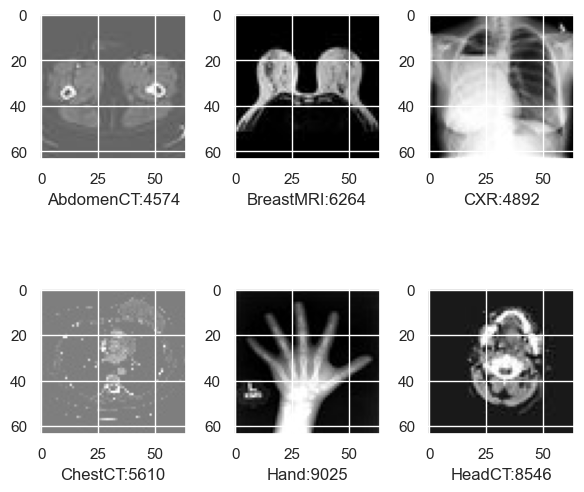

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: {'AbdomenCT': 10000, 'BreastMRI': 8954, 'CXR': 10000, 'ChestCT': 10000, 'Hand': 10000, 'HeadCT': 10000}
Keys: <KeysViewHDF5 ['imgs', 'latents']>
Number of frames: 737280
For HeadCT added 6000 train, 2000 val, 2000 test.
Train has 0/6000 sprited images, Val has 200/2000 sprited images, Test has 200/2000 sprited images, 


In [228]:
train_x,val_x,test_x = loadProperData("unsupervised_.1")

In [229]:
batch_size = 200
train_ds = MedNISTDataset(train_x)
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

val_ds = MedNISTDataset(val_x)
val_loader = DataLoader(val_ds, batch_size=batch_size)

test_ds = MedNISTDataset(test_x)
test_loader = DataLoader(test_ds, batch_size=batch_size)

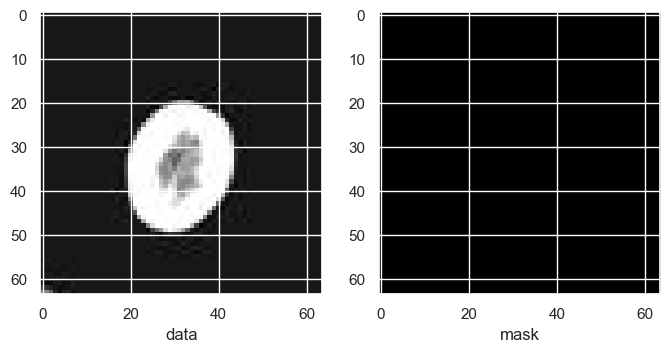

In [230]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"data")
plt.imshow(train_ds[2030][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"mask")
plt.imshow(train_ds[2030][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


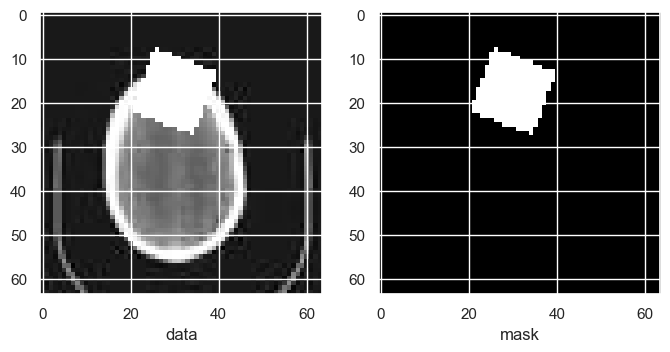

In [231]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"data")
plt.imshow(val_ds[101][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"mask")
plt.imshow(val_ds[101][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


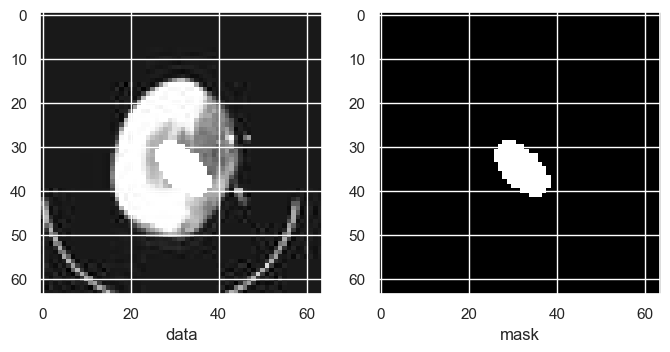

In [232]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"data")
plt.imshow(test_ds[101][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"mask")
plt.imshow(test_ds[101][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


In [251]:
encoderdict={'num_layers': 3, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'dilation': 1}
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = [3, 5, 5, 3]
encoderdict['stride'] = [1, 2, 2, 1]
encoderdict['padding'] = [1, 2, 2, 1]
encoderdict['dilation'] = [1, 1, 1, 1]
from custommodels import AutoEnc,ConstrainedAE
testmodel = AutoEnc(**encoderdict).to(device)

## Run AE Dense

In [78]:
def loadobjective(trial):
    experiment_type = "supervised_.1"
    from custommodels import AutoEnc,VAE
    train_x,val_x,test_x = loadProperData(experiment_type)
    batch_size = 200
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

    val_ds = MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = trial.suggest_float("lr", 0.00001, 0.001, log=True)
    b1= trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = trial.suggest_int('stride',2,2)
    encoderdict['padding'] = trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = trial.suggest_int('dilation',1,1)

    if experiment_type=="unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
        model_name="ae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="vae_unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
        model_name="vae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = VAE(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="supervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
        model_name="ae_model_s"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name)

In [81]:
lr_sup_study = optuna.create_study(direction="minimize",study_name="lr_sup_test_experiment")

lr_sup_study.optimize(loadobjective, n_trials=50,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = lr_sup_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = lr_sup_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(lr_sup_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = lr_sup_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-27 00:09:49,335] A new study created in memory with name: lr_sup_test_experiment


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00011819916895216714,(0.7492813758609335, 0.8353278358893297),0.0,custom,0.1,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4826
3/30, train_loss: 0.4677
4/30, train_loss: 0.4508
5/30, train_loss: 0.4448
6/30, train_loss: 0.4318
7/30, train_loss: 0.4204
8/30, train_loss: 0.4102
9/30, train_loss: 0.3960
10/30, train_loss: 0.3799
11/30, train_loss: 0.3760
12/30, train_loss: 0.3649
13/30, train_loss: 0.3472
14/30, train_loss: 0.3371
15/30, train_loss: 0.3275
16/30, train_loss: 0.3212
17/30, train_loss: 0.3086
18/30, train_loss: 0.3010
19/30, train_loss: 0.2905
20/30, train_loss: 0.2896
21/30, train_loss: 0.2801
22/30, train_loss: 0.2725
23/30, train_loss: 0.2663
24/30, train_loss: 0.2584
25/30, train_loss: 0.2467
26/30, train_loss: 0.2421
27/30, train_loss: 0.2368
28/30, tr

[I 2022-11-27 00:13:39,628] Trial 0 finished with value: 0.17823026180267335 and parameters: {'chosen_loss': 'custom', 'lr': 0.00011819916895216714, 'b1': 0.7492813758609335, 'b2': 0.8353278358893297, 'weight_decay': 0.0, 'gamma': 0.1, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 0 with value: 0.17823026180267335.


current epoch: 10 
current L1 reconstruction error mean: 0.2050 
AUROC: 0.9659 
AUPRC: 0.0623 
DICE score: 0.1110 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1782 at epoch: 1
train completed, best_metric: 0.1782 at epoch: 1
Saved model at ./models\ae_model_s_0-(0.00011819916895216714,0.1,3,5,2,1,1,custom,(0.7492813758609335, 0.8353278358893297),0.0).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0007522940549220691,(0.829147893287424, 0.8341232220021407),0.0,custom,0.1,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4519
3/30, train_loss: 0.4041
4/30, train_loss: 0.3589
5/30, train_loss: 0.3273
6/30, train_loss: 0.2923
7/30, train_loss: 0.2640
8/30, train_loss: 0.2382
9/30, train_loss: 0.2111
10/30, train_loss: 0.1867
11/30, train_loss: 0.1750
12/30, train_loss: 0.1933
13/30, train_loss: 0.1667
14/30

[I 2022-11-27 00:24:01,460] Trial 1 finished with value: 0.2083037093281746 and parameters: {'chosen_loss': 'custom', 'lr': 0.0007522940549220691, 'b1': 0.829147893287424, 'b2': 0.8341232220021407, 'weight_decay': 0.0, 'gamma': 0.1, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 0 with value: 0.17823026180267335.


current epoch: 10 
current L1 reconstruction error mean: 0.2676 
AUROC: 0.9408 
AUPRC: 0.0463 
DICE score: 0.0854 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.2083 at epoch: 1
train completed, best_metric: 0.2083 at epoch: 1
Saved model at ./models\ae_model_s_1-(0.0007522940549220691,0.1,3,5,2,1,1,custom,(0.829147893287424, 0.8341232220021407),0.0).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 4.344002973110999e-05,(0.8687285670531025, 0.8841847269259241),0.0,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4932
3/30, train_loss: 0.4858
4/30, train_loss: 0.4751
5/30, train_loss: 0.4754
6/30, train_loss: 0.4694
7/30, train_loss: 0.4648
8/30, train_loss: 0.4614
9/30, train_loss: 0.4547
10/30, train_loss: 0.4453
11/30, train_loss: 0.4481
12/30, train_loss: 0.4436
13/30, train_loss: 0.4323
14/30

[I 2022-11-27 00:28:11,092] Trial 2 finished with value: 0.17835579365491866 and parameters: {'chosen_loss': 'custom', 'lr': 4.344002973110999e-05, 'b1': 0.8687285670531025, 'b2': 0.8841847269259241, 'weight_decay': 0.0, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 0 with value: 0.17823026180267335.


current epoch: 10 
current L1 reconstruction error mean: 0.3496 
AUROC: 0.9538 
AUPRC: 0.0517 
DICE score: 0.0723 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1784 at epoch: 1
train completed, best_metric: 0.1784 at epoch: 1
Saved model at ./models\ae_model_s_2-(4.344002973110999e-05,0.05,3,5,2,1,1,custom,(0.8687285670531025, 0.8841847269259241),0.0).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 2.9998628251067668e-05,(0.7552175789668542, 0.8339446950838458),0.0002,custom,0.1,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4954
3/30, train_loss: 0.4897
4/30, train_loss: 0.4808
5/30, train_loss: 0.4820
6/30, train_loss: 0.4774
7/30, train_loss: 0.4739
8/30, train_loss: 0.4714
9/30, train_loss: 0.4657
10/30, train_loss: 0.4576
11/30, train_loss: 0.4612
12/30, train_loss: 0.4576
13/30, train_loss: 0.4473


[I 2022-11-27 00:32:51,604] Trial 3 finished with value: 0.17450313419103622 and parameters: {'chosen_loss': 'custom', 'lr': 2.9998628251067668e-05, 'b1': 0.7552175789668542, 'b2': 0.8339446950838458, 'weight_decay': 0.0002, 'gamma': 0.1, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 3 with value: 0.17450313419103622.


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 9.298913459858452e-05,(0.7657894795079174, 0.8345813544324654),0.0001,custom,0.0,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4859
3/30, train_loss: 0.4732
4/30, train_loss: 0.4581
5/30, train_loss: 0.4543
6/30, train_loss: 0.4434
7/30, train_loss: 0.4342
8/30, train_loss: 0.4262
9/30, train_loss: 0.4144
10/30, train_loss: 0.4003
11/30, train_loss: 0.3982
12/30, train_loss: 0.3888
13/30, train_loss: 0.3729
14/30, train_loss: 0.3647
15/30, train_loss: 0.3565
16/30, train_loss: 0.3510
17/30, train_loss: 0.3391
18/30, train_loss: 0.3318
19/30, train_loss: 0.3213
20/30, train_loss: 0.3208
21/30, train_loss: 0.3114
22/30, train_loss: 0.3038
23/30, train_loss: 0.2975
24/30, train_loss: 0.2898
25/30, train_loss: 0.2782
26/30, train_loss: 0.2732
27/30, train_loss: 0.2680
28/30, 

[I 2022-11-27 00:36:58,601] Trial 4 finished with value: 0.1807127982378006 and parameters: {'chosen_loss': 'custom', 'lr': 9.298913459858452e-05, 'b1': 0.7657894795079174, 'b2': 0.8345813544324654, 'weight_decay': 0.0001, 'gamma': 0.0, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 3 with value: 0.17450313419103622.


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0002601448317105473,(0.9183834989554991, 0.8486778739710457),0.0003,custom,0.0,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5007
2/30, train_loss: 0.4690
3/30, train_loss: 0.4455
4/30, train_loss: 0.4203
5/30, train_loss: 0.4071
6/30, train_loss: 0.3870
7/30, train_loss: 0.3695
8/30, train_loss: 0.3545
9/30, train_loss: 0.3358
10/30, train_loss: 0.3166
11/30, train_loss: 0.3098
12/30, train_loss: 0.2977
13/30, train_loss: 0.2803
14/30, train_loss: 0.2697
15/30, train_loss: 0.2605
16/30, train_loss: 0.2546
17/30, train_loss: 0.2424
18/30, train_loss: 0.2354
19/30, train_loss: 0.2256
20/30, train_loss: 0.2250
21/30, train_loss: 0.2160
22/30, train_loss: 0.2082
23/30, train_loss: 0.2020
24/30, train_loss: 0.1935
25/30, train_loss: 0.1820
26/30, train_loss: 0.1784
27/30, train_loss: 0.1729
28/30, 

[I 2022-11-27 00:42:40,107] Trial 5 finished with value: 0.15723775774240495 and parameters: {'chosen_loss': 'custom', 'lr': 0.0002601448317105473, 'b1': 0.9183834989554991, 'b2': 0.8486778739710457, 'weight_decay': 0.0003, 'gamma': 0.0, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 5 with value: 0.15723775774240495.


current epoch: 10 
current L1 reconstruction error mean: 0.1613 
AUROC: 0.9577 
AUPRC: 0.0527 
DICE score: 0.1012 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1572 at epoch: 1
train completed, best_metric: 0.1572 at epoch: 1
Saved model at ./models\ae_model_s_5-(0.0002601448317105473,0.0,3,5,2,1,1,custom,(0.9183834989554991, 0.8486778739710457),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00014485072669657975,(0.7006354608646604, 0.833426589119242),0.0,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4795
3/30, train_loss: 0.4624
4/30, train_loss: 0.4432
5/30, train_loss: 0.4347
6/30, train_loss: 0.4191
7/30, train_loss: 0.4051
8/30, train_loss: 0.3925
9/30, train_loss: 0.3759
10/30, train_loss: 0.3577
11/30, train_loss: 0.3513
12/30, train_loss: 0.3380
13/30, train_loss: 0.3191
1

[I 2022-11-27 00:46:35,633] Trial 6 finished with value: 0.1737184166908264 and parameters: {'chosen_loss': 'custom', 'lr': 0.00014485072669657975, 'b1': 0.7006354608646604, 'b2': 0.833426589119242, 'weight_decay': 0.0, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 5 with value: 0.15723775774240495.


current epoch: 10 
current L1 reconstruction error mean: 0.1861 
AUROC: 0.9677 
AUPRC: 0.0647 
DICE score: 0.1131 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1737 at epoch: 1
train completed, best_metric: 0.1737 at epoch: 1
Saved model at ./models\ae_model_s_6-(0.00014485072669657975,0.05,3,5,2,1,1,custom,(0.7006354608646604, 0.833426589119242),0.0).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00027453832014117795,(0.8897520983145304, 0.9821811548349062),0.0002,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4683
3/30, train_loss: 0.4436
4/30, train_loss: 0.4171
5/30, train_loss: 0.4025
6/30, train_loss: 0.3806
7/30, train_loss: 0.3620
8/30, train_loss: 0.3455
9/30, train_loss: 0.3252
10/30, train_loss: 0.3051
11/30, train_loss: 0.2973
12/30, train_loss: 0.2842
13/30, train_loss: 0.2659

[I 2022-11-27 00:50:53,840] Trial 7 finished with value: 0.14242829382419586 and parameters: {'chosen_loss': 'custom', 'lr': 0.00027453832014117795, 'b1': 0.8897520983145304, 'b2': 0.9821811548349062, 'weight_decay': 0.0002, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 7 with value: 0.14242829382419586.


current epoch: 10 
current L1 reconstruction error mean: 0.1425 
AUROC: 0.9617 
AUPRC: 0.0644 
DICE score: 0.1212 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1424 at epoch: 9
train completed, best_metric: 0.1424 at epoch: 9
Saved model at ./models\ae_model_s_7-(0.00027453832014117795,0.05,3,5,2,1,1,custom,(0.8897520983145304, 0.9821811548349062),0.0002).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00011963137332032778,(0.871493783897157, 0.875491195952006),0.0002,custom,0.0,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4823
3/30, train_loss: 0.4677
4/30, train_loss: 0.4509
5/30, train_loss: 0.4454
6/30, train_loss: 0.4331
7/30, train_loss: 0.4225
8/30, train_loss: 0.4134
9/30, train_loss: 0.4006
10/30, train_loss: 0.3856
11/30, train_loss: 0.3828
12/30, train_loss: 0.3729
13/30, train_loss: 0.356

[I 2022-11-27 00:51:18,217] Trial 8 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1838 
AUROC: 0.9749 
AUPRC: 0.0813 
DICE score: 0.1452 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1838 at epoch: 1
train completed, best_metric: 0.1838 at epoch: 1
Saved model at ./models\ae_model_s_8-(0.00011963137332032778,0.0,3,5,2,1,1,custom,(0.871493783897157, 0.875491195952006),0.0002).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00016559065499822313,(0.7339574645650767, 0.9701863214361778),0.0001,custom,0.1,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4771
3/30, train_loss: 0.4589
4/30, train_loss: 0.4379
5/30, train_loss: 0.4279
6/30, train_loss: 0.4106
7/30, train_loss: 0.3952
8/30, train_loss: 0.3811
9/30, train_loss: 0.3630
10/30, train_loss: 0.3432
11/30, train_loss: 0.3353
12/30, train_loss: 0.3215
13/30, train_loss: 0.3024


[I 2022-11-27 00:55:10,690] Trial 9 finished with value: 0.16815401017665862 and parameters: {'chosen_loss': 'custom', 'lr': 0.00016559065499822313, 'b1': 0.7339574645650767, 'b2': 0.9701863214361778, 'weight_decay': 0.0001, 'gamma': 0.1, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 7 with value: 0.14242829382419586.


current epoch: 10 
current L1 reconstruction error mean: 0.1682 
AUROC: 0.9696 
AUPRC: 0.0709 
DICE score: 0.1199 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1682 at epoch: 5
train completed, best_metric: 0.1682 at epoch: 5
Saved model at ./models\ae_model_s_9-(0.00016559065499822313,0.1,3,5,2,1,1,custom,(0.7339574645650767, 0.9701863214361778),0.0001).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0009540813726943018,(0.9411660877760376, 0.9740104147192091),0.0003,custom,0.15,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4485
3/30, train_loss: 0.3973
4/30, train_loss: 0.3490
5/30, train_loss: 0.3151
6/30, train_loss: 0.2795
7/30, train_loss: 0.2500
8/30, train_loss: 0.2231
9/30, train_loss: 0.1963
10/30, train_loss: 0.1759
11/30, train_loss: 0.1659
12/30, train_loss: 0.1599
13/30, train_loss: 0.15

[I 2022-11-27 00:56:24,646] Trial 10 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1994 
AUROC: 0.9455 
AUPRC: 0.0454 
DICE score: 0.0786 
Threshold: 0.8184 
best L1 reconstruction error mean: 0.1994 at epoch: 1
train completed, best_metric: 0.1994 at epoch: 1
Saved model at ./models\ae_model_s_10-(0.0009540813726943018,0.15,3,5,2,1,1,custom,(0.9411660877760376, 0.9740104147192091),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0003858321947319132,(0.9404296911614634, 0.9351096356465156),0.0003,custom,0.0,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4618
3/30, train_loss: 0.4311
4/30, train_loss: 0.4001
5/30, train_loss: 0.3809
6/30, train_loss: 0.3561
7/30, train_loss: 0.3349
8/30, train_loss: 0.3162
9/30, train_loss: 0.2959
10/30, train_loss: 0.2763
11/30, train_loss: 0.2686
12/30, train_loss: 0.2560
13/30, train_loss: 0.239

[I 2022-11-27 01:05:05,203] Trial 11 finished with value: 0.1449727565050125 and parameters: {'chosen_loss': 'custom', 'lr': 0.0003858321947319132, 'b1': 0.9404296911614634, 'b2': 0.9351096356465156, 'weight_decay': 0.0003, 'gamma': 0.0, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 7 with value: 0.14242829382419586.


current epoch: 10 
current L1 reconstruction error mean: 0.1460 
AUROC: 0.9545 
AUPRC: 0.0556 
DICE score: 0.1132 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1450 at epoch: 2
train completed, best_metric: 0.1450 at epoch: 2
Saved model at ./models\ae_model_s_11-(0.0003858321947319132,0.0,3,5,2,1,1,custom,(0.9404296911614634, 0.9351096356465156),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00042242238567551105,(0.9005568446356237, 0.9338371927146845),0.0003,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5025
2/30, train_loss: 0.5094
3/30, train_loss: 0.5070
4/30, train_loss: 0.4964
5/30, train_loss: 0.4907
6/30, train_loss: 0.4778
7/30, train_loss: 0.4655
8/30, train_loss: 0.4535
9/30, train_loss: 0.4384
10/30, train_loss: 0.4221
11/30, train_loss: 0.4284
12/30, train_loss: 0.4295
13/30, train_loss: 0.4

[I 2022-11-27 01:05:45,418] Trial 12 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.2126 
AUROC: 0.9708 
AUPRC: 0.0717 
DICE score: 0.1301 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.2126 at epoch: 1
train completed, best_metric: 0.2126 at epoch: 1
Saved model at ./models\ae_model_s_12-(0.00042242238567551105,0.05,3,5,2,1,1,custom,(0.9005568446356237, 0.9338371927146845),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0004161714322360258,(0.9480662599816999, 0.9327321936296653),0.0002,custom,0.0,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4608
3/30, train_loss: 0.4290
4/30, train_loss: 0.3968
5/30, train_loss: 0.3769
6/30, train_loss: 0.3516
7/30, train_loss: 0.3298
8/30, train_loss: 0.3110
9/30, train_loss: 0.2905
10/30, train_loss: 0.2709
11/30, train_loss: 0.2628
12/30, train_loss: 0.2499
13/30, train_loss: 0.23

[I 2022-11-27 01:14:54,236] Trial 13 finished with value: 0.1624051883816719 and parameters: {'chosen_loss': 'custom', 'lr': 0.0004161714322360258, 'b1': 0.9480662599816999, 'b2': 0.9327321936296653, 'weight_decay': 0.0002, 'gamma': 0.0, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 7 with value: 0.14242829382419586.


current epoch: 10 
current L1 reconstruction error mean: 0.1657 
AUROC: 0.9383 
AUPRC: 0.0465 
DICE score: 0.1026 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1624 at epoch: 4
train completed, best_metric: 0.1624 at epoch: 4
Saved model at ./models\ae_model_s_13-(0.0004161714322360258,0.0,3,5,2,1,1,custom,(0.9480662599816999, 0.9327321936296653),0.0002).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00035662469992247446,(0.8231993662186323, 0.936843039458374),0.0003,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5007
2/30, train_loss: 0.4632
3/30, train_loss: 0.4337
4/30, train_loss: 0.4027
5/30, train_loss: 0.3829
6/30, train_loss: 0.3569
7/30, train_loss: 0.3339
8/30, train_loss: 0.3141
9/30, train_loss: 0.2925
10/30, train_loss: 0.2713
11/30, train_loss: 0.2619
12/30, train_loss: 0.2481
13/30, train_loss: 0.23

[I 2022-11-27 01:18:57,839] Trial 14 finished with value: 0.12650819793343543 and parameters: {'chosen_loss': 'custom', 'lr': 0.00035662469992247446, 'b1': 0.8231993662186323, 'b2': 0.936843039458374, 'weight_decay': 0.0003, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


current epoch: 10 
current L1 reconstruction error mean: 0.1265 
AUROC: 0.9613 
AUPRC: 0.0702 
DICE score: 0.1339 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1265 at epoch: 9
train completed, best_metric: 0.1265 at epoch: 9
Saved model at ./models\ae_model_s_14-(0.00035662469992247446,0.05,3,5,2,1,1,custom,(0.8231993662186323, 0.936843039458374),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00028803733661067856,(0.8159554448262771, 0.9933067054100807),0.0002,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4670
3/30, train_loss: 0.4411
4/30, train_loss: 0.4135
5/30, train_loss: 0.3969
6/30, train_loss: 0.3733
7/30, train_loss: 0.3524
8/30, train_loss: 0.3334
9/30, train_loss: 0.3117
10/30, train_loss: 0.2908
11/30, train_loss: 0.2819
12/30, train_loss: 0.2676
13/30, train_loss: 0.

[I 2022-11-27 01:23:03,425] Trial 15 finished with value: 0.13428492844104767 and parameters: {'chosen_loss': 'custom', 'lr': 0.00028803733661067856, 'b1': 0.8159554448262771, 'b2': 0.9933067054100807, 'weight_decay': 0.0002, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 1.2471644015945244e-05,(0.803178450435017, 0.9123544013711417),0.0001,custom,0.15,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4983
3/30, train_loss: 0.4955
4/30, train_loss: 0.4890
5/30, train_loss: 0.4925
6/30, train_loss: 0.4897
7/30, train_loss: 0.4882
8/30, train_loss: 0.4875
9/30, train_loss: 0.4840
10/30, train_loss: 0.4778
11/30, train_loss: 0.4832
12/30, train_loss: 0.4815
13/30, train_loss: 0.4733
14/30, train_loss: 0.4726
15/30, train_loss: 0.4722
16/30, train_loss: 0.4737
17/30, train_loss: 0.4693
18/30, train_loss: 0.4685
19/30, train_loss: 0.4646
20/30, train_loss: 0.4698
21/30, train_loss: 0.4664
22/30, train_loss: 0.4643
23/30, train_loss: 0.4632
24/30, train_loss: 0.4607
25/30, train_loss: 0.4539
26/30, train_loss: 0.4516
27/30, train_loss: 0.4505
28/30,

[I 2022-11-27 01:23:28,117] Trial 16 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1737 
AUROC: 0.9772 
AUPRC: 0.0933 
DICE score: 0.1502 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1737 at epoch: 1
train completed, best_metric: 0.1737 at epoch: 1
Saved model at ./models\ae_model_s_16-(1.2471644015945244e-05,0.15,3,5,2,1,1,custom,(0.803178450435017, 0.9123544013711417),0.0001).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 6.230242425642081e-05,(0.8206528563762483, 0.9544989699121919),0.0003,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4903
3/30, train_loss: 0.4805
4/30, train_loss: 0.4682
5/30, train_loss: 0.4667
6/30, train_loss: 0.4589
7/30, train_loss: 0.4524
8/30, train_loss: 0.4470
9/30, train_loss: 0.4381
10/30, train_loss: 0.4267
11/30, train_loss: 0.4276
12/30, train_loss: 0.4207
13/30, train_loss: 0.40

[I 2022-11-27 01:23:52,483] Trial 17 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1808 
AUROC: 0.9756 
AUPRC: 0.0872 
DICE score: 0.1437 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1808 at epoch: 1
train completed, best_metric: 0.1808 at epoch: 1
Saved model at ./models\ae_model_s_17-(6.230242425642081e-05,0.05,3,5,2,1,1,custom,(0.8206528563762483, 0.9544989699121919),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0006323328894208584,(0.7895728000269848, 0.9948006471382871),0.0002,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4539
3/30, train_loss: 0.4098
4/30, train_loss: 0.3671
5/30, train_loss: 0.3372
6/30, train_loss: 0.3025
7/30, train_loss: 0.2750
8/30, train_loss: 0.2519
9/30, train_loss: 0.2277
10/30, train_loss: 0.2052
11/30, train_loss: 0.1933
12/30, train_loss: 0.1825
13/30, train_loss: 0.16

[I 2022-11-27 01:24:53,045] Trial 18 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1868 
AUROC: 0.9540 
AUPRC: 0.0506 
DICE score: 0.1055 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1868 at epoch: 1
train completed, best_metric: 0.1868 at epoch: 1
Saved model at ./models\ae_model_s_18-(0.0006323328894208584,0.05,3,5,2,1,1,custom,(0.7895728000269848, 0.9948006471382871),0.0002).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00021622485995312541,(0.8480532424820626, 0.9089644930574025),0.0003,custom,0.1,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4724
3/30, train_loss: 0.4512
4/30, train_loss: 0.4277
5/30, train_loss: 0.4158
6/30, train_loss: 0.3968
7/30, train_loss: 0.3799
8/30, train_loss: 0.3652
9/30, train_loss: 0.3466
10/30, train_loss: 0.3270
11/30, train_loss: 0.3196
12/30, train_loss: 0.3068
13/30, train_loss: 0.28

[I 2022-11-27 01:29:03,776] Trial 19 finished with value: 0.14895227998495103 and parameters: {'chosen_loss': 'custom', 'lr': 0.00021622485995312541, 'b1': 0.8480532424820626, 'b2': 0.9089644930574025, 'weight_decay': 0.0003, 'gamma': 0.1, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


current epoch: 10 
current L1 reconstruction error mean: 0.1490 
AUROC: 0.9643 
AUPRC: 0.0656 
DICE score: 0.1205 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1490 at epoch: 9
train completed, best_metric: 0.1490 at epoch: 9
Saved model at ./models\ae_model_s_19-(0.00021622485995312541,0.1,3,5,2,1,1,custom,(0.8480532424820626, 0.9089644930574025),0.0003).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0004929043595551152,(0.7885817144440022, 0.9537833005675367),0.0002,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4581
3/30, train_loss: 0.4209
4/30, train_loss: 0.3832
5/30, train_loss: 0.3580
6/30, train_loss: 0.3262
7/30, train_loss: 0.3004
8/30, train_loss: 0.2789
9/30, train_loss: 0.2553
10/30, train_loss: 0.2332
11/30, train_loss: 0.2226
12/30, train_loss: 0.2080
13/30, train_loss: 0.1

[I 2022-11-27 01:39:21,616] Trial 20 finished with value: 0.164467017352581 and parameters: {'chosen_loss': 'custom', 'lr': 0.0004929043595551152, 'b1': 0.7885817144440022, 'b2': 0.9537833005675367, 'weight_decay': 0.0002, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


current epoch: 10 
current L1 reconstruction error mean: 0.1832 
AUROC: 0.9466 
AUPRC: 0.0390 
DICE score: 0.0855 
Threshold: 0.8520 
best L1 reconstruction error mean: 0.1645 at epoch: 1
train completed, best_metric: 0.1645 at epoch: 1
Saved model at ./models\ae_model_s_20-(0.0004929043595551152,0.05,3,5,2,1,1,custom,(0.7885817144440022, 0.9537833005675367),0.0002).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00027119327701530233,(0.8617096222700923, 0.9925570647966482),0.0002,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4682
3/30, train_loss: 0.4435
4/30, train_loss: 0.4168
5/30, train_loss: 0.4019
6/30, train_loss: 0.3796
7/30, train_loss: 0.3605
8/30, train_loss: 0.3432
9/30, train_loss: 0.3226
10/30, train_loss: 0.3022
11/30, train_loss: 0.2942
12/30, train_loss: 0.2808
13/30, train_loss: 0.

[I 2022-11-27 01:43:29,141] Trial 21 finished with value: 0.14010785073041915 and parameters: {'chosen_loss': 'custom', 'lr': 0.00027119327701530233, 'b1': 0.8617096222700923, 'b2': 0.9925570647966482, 'weight_decay': 0.0002, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


current epoch: 10 
current L1 reconstruction error mean: 0.1401 
AUROC: 0.9631 
AUPRC: 0.0680 
DICE score: 0.1269 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1401 at epoch: 9
train completed, best_metric: 0.1401 at epoch: 9
Saved model at ./models\ae_model_s_21-(0.00027119327701530233,0.05,3,5,2,1,1,custom,(0.8617096222700923, 0.9925570647966482),0.0002).pth.
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00026794476549148725,(0.844916956044746, 0.9930964926918383),0.0001,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4684
3/30, train_loss: 0.4438
4/30, train_loss: 0.4174
5/30, train_loss: 0.4022
6/30, train_loss: 0.3797
7/30, train_loss: 0.3603
8/30, train_loss: 0.3428
9/30, train_loss: 0.3216
10/30, train_loss: 0.3012
11/30, train_loss: 0.2930
12/30, train_loss: 0.2793
13/30, train_loss: 0.

[I 2022-11-27 01:47:34,544] Trial 22 finished with value: 0.13950995355844498 and parameters: {'chosen_loss': 'custom', 'lr': 0.00026794476549148725, 'b1': 0.844916956044746, 'b2': 0.9930964926918383, 'weight_decay': 0.0001, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.00021855187798834613,(0.8294925346265805, 0.9574173602818546),0.0001,custom,0.05,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5006
2/30, train_loss: 0.4723
3/30, train_loss: 0.4506
4/30, train_loss: 0.4269
5/30, train_loss: 0.4144
6/30, train_loss: 0.3950
7/30, train_loss: 0.3777
8/30, train_loss: 0.3623
9/30, train_loss: 0.3430
10/30, train_loss: 0.3226
11/30, train_loss: 0.3148
12/30, train_loss: 0.3015
13/30, train_loss: 0.2831
14/30, train_loss: 0.2716
15/30, train_loss: 0.2620
16/30, train_loss: 0.2555
17/30, train_loss: 0.2433
18/30, train_loss: 0.2358
19/30, train_loss: 0.2256
20/30, train_loss: 0.2245
21/30, train_loss: 0.2150
22/30, train_loss: 0.2071
23/30, train_loss: 0.2011
24/30, train_loss: 0.1929
25/30, train_loss: 0.1815
26/30, train_loss: 0.1783
27/30, train_loss: 0.1732
28/30

[I 2022-11-27 01:51:55,745] Trial 23 finished with value: 0.15474959164857865 and parameters: {'chosen_loss': 'custom', 'lr': 0.00021855187798834613, 'b1': 0.8294925346265805, 'b2': 0.9574173602818546, 'weight_decay': 0.0001, 'gamma': 0.05, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}. Best is trial 14 with value: 0.12650819793343543.


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
Testing model with parameters: 0.0005894927931914674,(0.8456552218525396, 0.9173222758862124),0.0001,custom,0.1,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
making model...
----------
epoch 1/10
1/30, train_loss: 0.5005
2/30, train_loss: 0.4552
3/30, train_loss: 0.4203
4/30, train_loss: 0.3825
5/30, train_loss: 0.3568
6/30, train_loss: 0.3249
7/30, train_loss: 0.2986
8/30, train_loss: 0.2765
9/30, train_loss: 0.2524
10/30, train_loss: 0.2303
11/30, train_loss: 0.2198
12/30, train_loss: 0.2063
13/30, train_loss: 0.1904
14/30, train_loss: 0.1783
15/30, train_loss: 0.1691
16/30, train_loss: 0.1607
17/30, train_loss: 0.1491
18/30, train_loss: 0.1424
19/30, train_loss: 0.1362
20/30, train_loss: 0.1355
21/30, train_loss: 0.1303
22/30, train_loss: 0.1287
23/30, train_loss: 0.1251
24/30, train_loss: 0.1221
25/30, train_loss: 0.1147
26/30, train_loss: 0.1199
27/30, train_loss: 0.1181
28/30, 

[W 2022-11-27 01:55:18,796] Trial 24 failed because of the following error: MemoryError((8192000,), dtype('float64'))
Traceback (most recent call last):
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_49264\1034962370.py", line 41, in loadobjective
    return objective(trial,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name)
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_49264\206490241.py", line 98, in objective
    diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",customname,str(epoch+1))
  File "c:\Users\irose\Desktop\SCHOOL\CS274E\CS-274E-Brain-Segmentation\customfunctions.py", line 181, in metrics
    filename=os.path.join(folder, f'rocPC_{filename}.png'))
  File "c:\Users\irose\Desktop\SCHOOL\CS274E\CS-274E-Brain-Segmentation\customfunctions.py", line 2

MemoryError: Unable to allocate 62.5 MiB for an array with shape (8192000,) and data type float64

In [82]:

print("Best trial:")
trial = lr_sup_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.12650819793343543
  Params: 
    chosen_loss: custom
    lr: 0.00035662469992247446
    b1: 0.8231993662186323
    b2: 0.936843039458374
    weight_decay: 0.0003
    gamma: 0.05
    num_layers: 3
    kernel_size: 5
    stride: 2
    padding: 1
    dilation: 1


: 

## Else

In [32]:
def loadobjective(trial):
    experiment_type = "vae_unsupervised_.1"
    from custommodels import AutoEnc,VAE
    train_x,val_x,test_x = loadProperData(experiment_type)
    batch_size = 200
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

    val_ds = MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = trial.suggest_float("lr", 0.0001, 0.001, log=True)
    b1= trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = trial.suggest_int('stride',2,2)
    encoderdict['padding'] = trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = trial.suggest_int('dilation',1,1)


    if experiment_type=="unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
        model_name="ae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="vae_unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
        model_name="vae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = VAE(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="supervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
        model_name="ae_model_s"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name)

In [35]:
vae_study = optuna.create_study(direction="minimize",study_name="vae-test")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-27 03:42:29,197] A new study created in memory with name: vae-test


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
making model...
Testing model with parameters: 0.00031242864592003524,(0.8954876073858805, 0.80150460838993),0.0,KL,0.0,{'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1}
----------
epoch 1/10
1/30, train_loss: 1907.5778
2/30, train_loss: 1840.6538
3/30, train_loss: 1790.9084
4/30, train_loss: 1738.2869
5/30, train_loss: 1696.1239
6/30, train_loss: 1651.9509
7/30, train_loss: 1565.1219
8/30, train_loss: 1523.5665
9/30, train_loss: 1510.7384
10/30, train_loss: 1455.6027
11/30, train_loss: 1438.4857
12/30, train_loss: 1365.8622
13/30, train_loss: 1321.1813
14/30, train_loss: 1288.3751
15/30, train_loss: 1264.9901
16/30, train_loss: 1215.5602
17/30, train_loss: 1182.6522
18/30, train_loss: 1150.4489
19/30, train_loss: 1118.3395
20/30, train_loss: 1099.6786
21/30, train_loss: 1058.4628
22/30, train_loss: 1045.0778
23/30, train_loss: 1022.9468
24/30, train_loss: 971.5264
25/30, train_loss: 965

[I 2022-11-27 03:45:52,934] Trial 0 finished with value: 846.9456359863282 and parameters: {'lr': 0.00031242864592003524, 'b1': 0.8954876073858805, 'b2': 0.80150460838993, 'weight_decay': 0.0, 'gamma': 0.0, 'num_layers': 3, 'kernel_size': 5, 'stride': 2, 'padding': 1, 'dilation': 1, 'chosen_loss': 'KL'}. Best is trial 0 with value: 846.9456359863282.


current epoch: 10 
current KL loss mean: 847.0250 
AUROC: 0.9723 
AUPRC: 0.0675 
DICE score: 0.1372 
Threshold: 0.9000 
best KL loss mean: 846.9456 at epoch: 8
train completed, best_metric: 846.9456 at epoch: 8
Saved model at ./models\vae_model_us_0-(0.00031242864592003524,0.0,3,5,2,1,1,KL,(0.8954876073858805, 0.80150460838993),0.0).pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  846.9456359863282
  Params: 
    lr: 0.00031242864592003524
    b1: 0.8954876073858805
    b2: 0.80150460838993
    weight_decay: 0.0
    gamma: 0.0
    num_layers: 3
    kernel_size: 5
    stride: 2
    padding: 1
    dilation: 1
    chosen_loss: KL


In [23]:
import joblib
joblib.dump(refine_study, "ae_refine_experiment.pkl")

['ae_refine_experiment.pkl']

In [24]:

print("Best trial:")
trial = refine_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.08622895367443562
  Params: 
    lr: 0.001341399398779975
    b1: 0.7065972063449719
    b2: 0.9222972304554699
    weight_decay: 0.00030000000000000003
    chosen_loss: L1
    gamma: 0.15000000000000002
    num_layers: 3
    kernel_size: 5
    stride: 2
    padding: 1
    dilation: 1


In [25]:
statlist = []
for v in refine_study.trials:
    num = v.number
    state = v.state
    params = v.params.values()
    scores = list(v.intermediate_values.values())
    if len(scores)<1:
        scores = [100000]
    statlist.append((num,state,params,scores[-1]))
print(sorted(statlist,key=lambda x: x[3]))

[(13, TrialState.COMPLETE, dict_values([0.001341399398779975, 0.7065972063449719, 0.9222972304554699, 0.00030000000000000003, 'L1', 0.15000000000000002, 3, 5, 2, 1, 1]), 0.08623030968010426), (12, TrialState.COMPLETE, dict_values([0.001341399398779975, 0.7026854432757517, 0.9341168485705258, 0.00030000000000000003, 'L1', 0.15000000000000002, 3, 5, 2, 1, 1]), 0.08662827219814062), (10, TrialState.COMPLETE, dict_values([0.001341399398779975, 0.707698198893824, 0.9235535440175436, 0.00030000000000000003, 'L1', 0.1, 3, 5, 2, 1, 1]), 0.08727010246366262), (14, TrialState.FAIL, dict_values([0.001341399398779975, 0.747533629898042, 0.9223848341497471, 0.0002, 'L1', 0.15000000000000002, 3, 5, 2, 1, 1]), 0.08805030770599842), (11, TrialState.COMPLETE, dict_values([0.001341399398779975, 0.7062087376922773, 0.9241265578881243, 0.0004, 'L1', 0.1, 3, 5, 2, 1, 1]), 0.08817333914339542), (0, TrialState.COMPLETE, dict_values([0.001341399398779975, 0.8571146822207698, 0.8142354772661643, 0.0005, 'L1', 

## Debugging Memory

In [11]:
memDebugger()

CPU Usage (%): 11.6
svmem(total=34187886592, available=15007244288, percent=56.1, used=19180642304, free=15007244288)
Memory (GB): 0.5007133483886719
Torch objects:
<class 'torch.Tensor'> torch.Size([])


c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\torch\distributed\distributed_c10d.py:263: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


In [42]:
ar1 = [1,2,3,4,5]
ar2 = ar1
ar2.append(1)
print(ar1,ar2)

[1, 2, 3, 4, 5, 1] [1, 2, 3, 4, 5, 1]


In [25]:
def loadobjective(trial):
    experiment_type = "unsupervised_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    train_x,val_x,test_x = loadProperData(experiment_type)
    batch_size = 125
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)


    #train_loader=torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=True,download=True,
    #transform=torchvision.transforms.Compose([
    #    torchvision.transforms.ToTensor(),
    #    torchvision.transforms.Resize(64)
    #])),
    #batch_size=200,shuffle=False)

    #val_loader=torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=True,download=True,
    #transform=torchvision.transforms.Compose([
    #    torchvision.transforms.ToTensor(),
    #    torchvision.transforms.Resize(64)
    #])),
    #batch_size=200,shuffle=False)


    val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.0008603126707594238 #trial.suggest_float("lr", 0.0005, 0.001, log=True)
    b1= 0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = 0.0 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [1,2,3,4] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,2,1,1] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)


    if experiment_type=="unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
        model_name="ae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            #model = babysfirstAE(**encoderdict).to(device)
            #model = SkipAE(**encoderdict).to(device)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            print(str(e))
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="vae_unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
        model_name="vae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = VAE(**encoderdict).to(device)
        except Exception as e: 
            print(str(e))
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="vae_supervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_supervised"])
        model_name="vae_model_s"
        try:
            print("making model...")
            #print(encoderdict)
            model = VAE(**encoderdict).to(device)
        except Exception as e: 
            print(str(e))
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="cae_unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
        model_name="cae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = ConstrainedAE(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="supervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
        model_name="ae_model_s"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc_NoBottleneck(**encoderdict).to(device) #SkipAE(**encoderdict).to(device)
        except Exception as e: 
            print(str(e))
            raise optuna.exceptions.TrialPruned()
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name)

[I 2022-12-05 03:51:55,412] A new study created in memory with name: vae-test


Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
making model...
Testing model with parameters: 0.0008603126707594238,(0.7486940959505869, 0.8806252210130728),0.0002,custom,0.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/5
1/48, train_loss: 0.3712
2/48, train_loss: 0.3351
3/48, train_loss: 0.3059
4/48, train_loss: 0.2834
5/48, train_loss: 0.2777
6/48, train_loss: 0.2614
7/48, train_loss: 0.2479
8/48, train_loss: 0.2552
9/48, train_loss: 0.2292
10/48, train_loss: 0.2280
11/48, train_loss: 0.2227
12/48, train_loss: 0.2224
13/48, train_loss: 0.2127
14/48, train_loss: 0.2121
15/48, train_loss: 0.2010
16/48, train_loss: 0.1949
17/48, train_loss: 0.2069
18/48, train_loss: 0.2112
19/48, train_loss: 0.2049
20/48, train_loss: 0.1889
21/48, train_loss: 0.1937
22/48, train_loss: 0.1824
23/48, train_loss: 0.1865
24/48, train_loss: 0.1808
25/48, train_loss: 0.1762
26/48, train_los

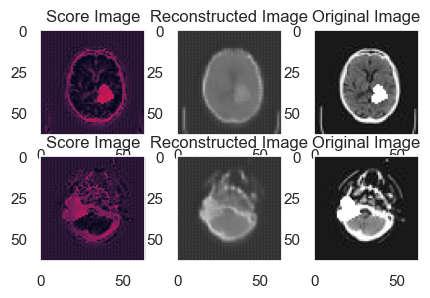

current epoch: 1 
current custom loss mean: 0.1381 
best custom loss mean: 0.1381 at epoch: 1
----------
epoch 2/5
1/48, train_loss: 0.1124
2/48, train_loss: 0.1151
3/48, train_loss: 0.1163
4/48, train_loss: 0.1212
5/48, train_loss: 0.1217
6/48, train_loss: 0.1167
7/48, train_loss: 0.1185
8/48, train_loss: 0.1244
9/48, train_loss: 0.1159
10/48, train_loss: 0.1157
11/48, train_loss: 0.1198
12/48, train_loss: 0.1146
13/48, train_loss: 0.1143
14/48, train_loss: 0.1180
15/48, train_loss: 0.1172
16/48, train_loss: 0.1170
17/48, train_loss: 0.1127
18/48, train_loss: 0.1176
19/48, train_loss: 0.1179
20/48, train_loss: 0.1091
21/48, train_loss: 0.1176
22/48, train_loss: 0.1174
23/48, train_loss: 0.1242
24/48, train_loss: 0.1215
25/48, train_loss: 0.1143
26/48, train_loss: 0.1167
27/48, train_loss: 0.1188
28/48, train_loss: 0.1150
29/48, train_loss: 0.1130
30/48, train_loss: 0.1070
31/48, train_loss: 0.1128
32/48, train_loss: 0.1164
33/48, train_loss: 0.1140
34/48, train_loss: 0.1163
35/48, tra

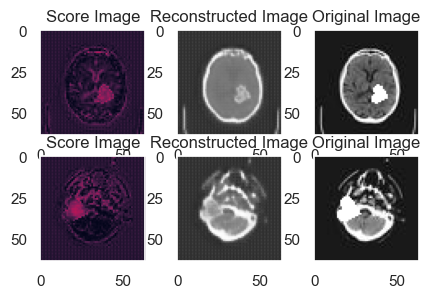

current epoch: 2 
current custom loss mean: 0.1177 
best custom loss mean: 0.1177 at epoch: 2
----------
epoch 3/5
1/48, train_loss: 0.1169
2/48, train_loss: 0.1216
3/48, train_loss: 0.1214
4/48, train_loss: 0.1157
5/48, train_loss: 0.1130
6/48, train_loss: 0.1132
7/48, train_loss: 0.1158
8/48, train_loss: 0.1152
9/48, train_loss: 0.1193
10/48, train_loss: 0.1138
11/48, train_loss: 0.1137
12/48, train_loss: 0.1237
13/48, train_loss: 0.1199
14/48, train_loss: 0.1207
15/48, train_loss: 0.1186
16/48, train_loss: 0.1125
17/48, train_loss: 0.1145
18/48, train_loss: 0.1165
19/48, train_loss: 0.1176
20/48, train_loss: 0.1174
21/48, train_loss: 0.1135
22/48, train_loss: 0.1177
23/48, train_loss: 0.1181
24/48, train_loss: 0.1106
25/48, train_loss: 0.1098
26/48, train_loss: 0.1222
27/48, train_loss: 0.1168
28/48, train_loss: 0.1126
29/48, train_loss: 0.1201
30/48, train_loss: 0.1218
31/48, train_loss: 0.1118
32/48, train_loss: 0.1196
33/48, train_loss: 0.1165
34/48, train_loss: 0.1211
35/48, tra

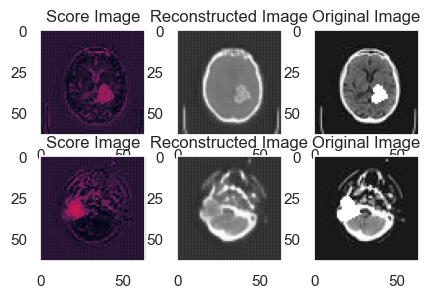

current epoch: 3 
current custom loss mean: 0.1156 
best custom loss mean: 0.1156 at epoch: 3
----------
epoch 4/5
1/48, train_loss: 0.1081
2/48, train_loss: 0.1188
3/48, train_loss: 0.1216
4/48, train_loss: 0.1205
5/48, train_loss: 0.1165
6/48, train_loss: 0.1189
7/48, train_loss: 0.1203
8/48, train_loss: 0.1145
9/48, train_loss: 0.1157
10/48, train_loss: 0.1174
11/48, train_loss: 0.1087
12/48, train_loss: 0.1173
13/48, train_loss: 0.1207
14/48, train_loss: 0.1191
15/48, train_loss: 0.1139
16/48, train_loss: 0.1139
17/48, train_loss: 0.1171
18/48, train_loss: 0.1102
19/48, train_loss: 0.1146
20/48, train_loss: 0.1171
21/48, train_loss: 0.1121
22/48, train_loss: 0.1157
23/48, train_loss: 0.1147
24/48, train_loss: 0.1133
25/48, train_loss: 0.1220
26/48, train_loss: 0.1113
27/48, train_loss: 0.1165
28/48, train_loss: 0.1179
29/48, train_loss: 0.1132
30/48, train_loss: 0.1142
31/48, train_loss: 0.1138
32/48, train_loss: 0.1128
33/48, train_loss: 0.1205
34/48, train_loss: 0.1204
35/48, tra

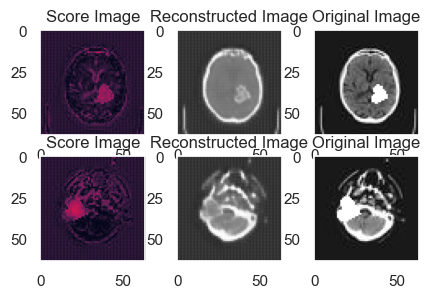

current epoch: 4 
current custom loss mean: 0.1164 
best custom loss mean: 0.1156 at epoch: 3
----------
epoch 5/5
1/48, train_loss: 0.1206
2/48, train_loss: 0.1220
3/48, train_loss: 0.1165
4/48, train_loss: 0.1208
5/48, train_loss: 0.1153
6/48, train_loss: 0.1208
7/48, train_loss: 0.1182
8/48, train_loss: 0.1151
9/48, train_loss: 0.1124
10/48, train_loss: 0.1169
11/48, train_loss: 0.1123
12/48, train_loss: 0.1209
13/48, train_loss: 0.1261
14/48, train_loss: 0.1189
15/48, train_loss: 0.1163
16/48, train_loss: 0.1159


[W 2022-12-05 03:54:20,459] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_68484\3620961868.py", line 102, in loadobjective
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name)
  File "c:\Users\irose\Desktop\SCHOOL\CS274E\CS-274E-Brain-Segmentation\customfunctions.py", line 407, in objective
    epoch_loss = train(model,train_loader,optimizer,loss_function,chosen_loss,device)
  File "c:\Users\irose\Desktop\SCHOOL\CS274E\CS-274E-Brain-Segmentation\customfunctions.py", line 291, in train
    loss.backward()
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\torch\_tensor.py", line 488, in backward
    self, gradient, retain_graph, create_graph, inputs=in

KeyboardInterrupt: 

In [26]:
vae_study = optuna.create_study(direction="minimize",study_name="vae-test")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
gc.collect()

In [214]:
gc.collect()
torch.cuda.empty_cache()



In [40]:
memDebugger()

CPU Usage (%): 11.9
svmem(total=34187886592, available=12885868544, percent=62.3, used=21302018048, free=12885868544)
Memory (GB): 3.280437469482422
Torch objects:
<class 'torch.Tensor'> torch.Size([]) 80
<class 'torch.Tensor'> torch.Size([32, 1, 1, 1]) 80
<class 'torch.Tensor'> torch.Size([32]) 80
<class 'torch.Tensor'> torch.Size([32]) 80
<class 'torch.Tensor'> torch.Size([32]) 80
<class 'torch.Tensor'> torch.Size([64, 32, 2, 2]) 80
<class 'torch.Tensor'> torch.Size([64]) 80
<class 'torch.Tensor'> torch.Size([64]) 80
<class 'torch.Tensor'> torch.Size([64]) 80
<class 'torch.Tensor'> torch.Size([128, 64, 3, 3]) 80
<class 'torch.Tensor'> torch.Size([128]) 80
<class 'torch.Tensor'> torch.Size([128]) 80
<class 'torch.Tensor'> torch.Size([128]) 80
<class 'torch.Tensor'> torch.Size([128, 128, 4, 4]) 80
<class 'torch.Tensor'> torch.Size([128]) 80
<class 'torch.Tensor'> torch.Size([128]) 80
<class 'torch.Tensor'> torch.Size([128]) 80
<class 'torch.Tensor'> torch.Size([128, 128, 5, 5]) 80
<cla

## Debugging via MNIST Digit Dataset

In [130]:
def modobjective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name):
    best_metric=None
    max_epochs = 10
    val_interval = 1
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=betas,weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    if chosen_loss=="L1":
        loss_function = nn.L1Loss()
        score_function = nn.L1Loss(reduction='none')
    elif chosen_loss=="KL":
        def kl_loss(pred,real,mu,sigma):
            l1_loss = nn.L1Loss(reduction='none')(pred,real)
            rec = torch.sum(l1_loss, axis=[1, 2, 3])
            kl = .5 * torch.sum(torch.square(mu)+torch.square(sigma)-torch.log(torch.square(sigma))-1,axis=1)
            rec - torch.mean(rec,axis=-1)
            kl = torch.mean(kl,axis=-1)
            print("REC:",torch.mean(rec),"KL:",torch.mean(kl))
            return torch.mean(rec+kl)

        loss_function = kl_loss
        score_function = nn.L1Loss(reduction='none')
    elif chosen_loss=="custom": 
        def anomaly_score(pred,real):
            return torch.abs(pred-real)
        def maskloss(pred,real,mask,reduction='mean'):
            def formula(pred,real,mask):
                anom = anomaly_score(pred,real)
                anom_mod = anom.clone()
                anom_mod[anom_mod==0]=1e-6
                return (1 - mask)*anom + mask/anom_mod
            res = formula(pred,real,mask)
            if reduction=='mean':
                return torch.mean(res)
            else:
                return res
        loss_function = maskloss
        score_function = anomaly_score
    elif chosen_loss=="custom2": 
        def anomaly_score(pred,real):
            return torch.abs(pred-real)
        def maskloss(pred,real,mask,reduction='mean'):
            def formula(pred,real,mask):
                anom = anomaly_score(pred,real)
                #anom_mod = anom.clone()
                anom[anom==1]=.99
                anom[anom==0]=1e-4
                return -(1 - mask)*torch.log(1-anom) - mask*torch.log(anom)
            res = formula(pred,real,mask)
            if reduction=='mean':
                return torch.mean(res)
            else:
                return res
        loss_function = maskloss
        score_function = anomaly_score
    else:
        raise ValueError(f"chosen loss {chosen_loss} invalid")


    customname = f"{trial.number}-({lr},{gamma},{encoderdict['num_layers']},{encoderdict['kernel_size']},"\
        f"{encoderdict['stride']},{encoderdict['padding']},{encoderdict['dilation']},{chosen_loss},{betas},{weight_decay})"
    modelfolder = "./models"
    if not os.path.exists(modelfolder):
        os.makedirs(modelfolder)
    
    datadict = dict()
    datadict["val_losses"] = []
    datadict["train_losses"] = []
    model.eval()
    with torch.no_grad():
        loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function,chosen_loss,device)
    
        y_stat = score_function(y_pred,y_true).cpu().numpy()

        y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask.cpu(), detach=False)])
        y_true_np = np.array([i.numpy() for i in decollate_batch(y_true.cpu(),detach=False)])
        y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred.cpu())])

        look_num = 49 #46 #1000 #1 #304
        look_num2 = 2
        plt.subplots(1,2, figsize=(15, 3))
        plt.subplot(1,4,1)
        plt.imshow(y_pred_np[look_num][0], cmap="gray", vmin=0, vmax=1)
        plt.title("Reconstructed Image")
        plt.subplot(1,4,2)
        plt.imshow(y_true_np[look_num][0], cmap="gray", vmin=0, vmax=1)
        plt.title("Original Image")
        plt.subplot(1,4,3)
        plt.imshow(y_pred_np[look_num2][0], cmap="gray", vmin=0, vmax=1)
        plt.title("Reconstructed Image")
        plt.subplot(1,4,4)
        plt.imshow(y_true_np[look_num2][0], cmap="gray", vmin=0, vmax=1)
        plt.title("Original Image")
        plt.show()

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        epoch_loss = train(model,train_loader,optimizer,loss_function,chosen_loss,device)
        print(f"TRAIN: epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        datadict["train_losses"].append(epoch_loss)
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function,chosen_loss,device)
            
                y_stat = score_function(y_pred,y_true).cpu().numpy()

                y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask.cpu(), detach=False)])
                y_true_np = np.array([i.numpy() for i in decollate_batch(y_true.cpu(),detach=False)])
                y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred.cpu())])

                look_num = 49 #46 #1000 #1 #304
                look_num2 = 2
                plt.subplots(1,2, figsize=(15, 3))
                plt.subplot(1,4,1)
                plt.imshow(y_pred_np[look_num][0], cmap="gray", vmin=0, vmax=1)
                plt.title("Reconstructed Image")
                plt.subplot(1,4,2)
                plt.imshow(y_true_np[look_num][0], cmap="gray", vmin=0, vmax=1)
                plt.title("Original Image")
                plt.subplot(1,4,3)
                plt.imshow(y_pred_np[look_num2][0], cmap="gray", vmin=0, vmax=1)
                plt.title("Reconstructed Image")
                plt.subplot(1,4,4)
                plt.imshow(y_true_np[look_num2][0], cmap="gray", vmin=0, vmax=1)
                plt.title("Original Image")
                plt.show()

                #reconstruction_err = np.sum(loss_values)
                avg_reconstruction_err = np.mean(loss_values)
                datadict["val_losses"].append(avg_reconstruction_err)
                if best_metric == None or avg_reconstruction_err < best_metric:
                    best_metric = avg_reconstruction_err
                    best_metric_epoch = epoch + 1
                
                #testtwodice(y_stat,y_mask_np)
                #print(np.unique(y_stat),np.unique(y_mask_np))
                #print("min",torch.min(y_stat),"max",torch.max(y_stat))
                
                #diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",customname,str(epoch+1))
                scheduler.step()
                print(
                    f"current epoch: {epoch + 1}",
                    f"\ncurrent {chosen_loss} loss mean: {avg_reconstruction_err:.4f}",
                    #f"\nAUROC: {diff_auc:.4f}",
                    #f"\nAUPRC: {diff_auprc:.4f}",
                    #f"\nDICE score: {diceScore:.4f}",
                    #f"\nThreshold: {diceThreshold:.4f}",
                    f"\nbest {chosen_loss} loss mean: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )
                trial.report(avg_reconstruction_err, epoch)
                # Handle pruning based on the intermediate value.
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

    return best_metric

In [11]:
def loadobjective(trial):
    print("test run")
    experiment_type = "vae_unsupervised_.1"
    from custommodels import AutoEnc,VAE
    train_x,val_x,test_x = loadProperData(experiment_type)
    batch_size = 200
    #train_ds = MedNISTDataset(train_x)
    #train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

    train_loader=torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=True,download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(64)
    ])),
    batch_size=200,shuffle=True)

    #val_ds = MedNISTDataset(val_x)
    #val_loader = DataLoader(val_ds, batch_size=batch_size)

    val_loader=torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=False,download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(64)
    ])),
    batch_size=200)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = trial.suggest_float("lr", 0.0001, 0.001, log=True)
    b1= trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = trial.suggest_int('stride',2,2)
    encoderdict['padding'] = trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = trial.suggest_int('dilation',1,1)


    if experiment_type=="unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
        model_name="ae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="vae_unsupervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
        model_name="vae_model_us"
        try:
            print("making model...")
            #print(encoderdict)
            model = VAE(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    elif experiment_type=="supervised_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
        model_name="ae_model_s"
        try:
            print("making model...")
            #print(encoderdict)
            model = AutoEnc(**encoderdict).to(device)
        except Exception as e: 
            raise optuna.exceptions.TrialPruned()
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    return modobjective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,model_name)

In [13]:
vae_study = optuna.create_study(direction="minimize",study_name="test")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-02 14:59:01,207] A new study created in memory with name: test
[I 2022-12-02 14:59:01,321] Trial 0 pruned. 


test run
Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.
making model...
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  1
  Number of complete trials:  0
Best trial:


ValueError: No trials are completed yet.

In [80]:
import torchvision
digit_train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=True,download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(64)
    ])),
    batch_size=200,shuffle=True)

In [ ]:
look_num =  #49 #46 #1000 #1 #304
plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,5,1)
plt.imshow(y_pred[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,2)
plt.imshow(y_true[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

In [71]:
i=0
for batch in digit_train_loader:
    i+=1
    if i==1:
        print(np.unique(batch[0][0]))
    if i==30:
        break

[0.00000000e+00 2.68076001e-05 8.04227966e-05 1.83823548e-04
 2.64246337e-04 3.67647095e-04 4.02114005e-04 7.65931443e-04
 7.77420413e-04 1.04166672e-03 1.14506739e-03 1.20634201e-03
 1.49739592e-03 1.51654414e-03 1.79227954e-03 1.89950992e-03
 2.08333344e-03 2.19822302e-03 2.27481616e-03 2.33226107e-03
 2.65395222e-03 2.73054536e-03 2.75735301e-03 2.91053928e-03
 3.19010415e-03 3.43520241e-03 3.44669120e-03 3.72242671e-03
 3.79901985e-03 3.96369491e-03 4.10156278e-03 4.23177099e-03
 4.48069861e-03 4.58027003e-03 4.73345583e-03 4.95940587e-03
 5.17003704e-03 5.33088250e-03 5.37683861e-03 5.51470602e-03
 5.81341935e-03 5.87469386e-03 5.91681991e-03 6.03170972e-03
 6.59466954e-03 6.78232219e-03 6.83593750e-03 6.92019006e-03
 7.13465130e-03 7.21890340e-03 7.26485951e-03 7.34145241e-03
 7.66314333e-03 8.06525815e-03 8.41375627e-03 8.59375019e-03
 8.78906250e-03 9.30606667e-03 9.51286778e-03 9.57031269e-03
 1.03745405e-02 1.04051782e-02 1.06617650e-02 1.06885722e-02
 1.10600498e-02 1.112132

## Test Made Models

In [238]:
'''
Best trial:
  Value:  0.08622895367443562
  Params: 
    lr: 0.001341399398779975
    b1: 0.7065972063449719
    b2: 0.9222972304554699
    weight_decay: 0.00030000000000000003
    chosen_loss: L1
    gamma: 0.15000000000000002
    num_layers: 3
    kernel_size: 5
    stride: 2
    padding: 1
    dilation: 1
'''
from custommodels import AutoEnc
lr = 0.001341399398779975
b1= 0.7065972063449719
b2= 0.9222972304554699
beta = (b1,b2)
weight_decay = 0.00030000000000000003
chosen_loss = "L1"
gamma = 0.15000000000000002
encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = [3, 5, 5, 3]
encoderdict['stride'] = [1, 2, 2, 1]
encoderdict['padding'] = [1, 2, 2, 1]
encoderdict['dilation'] = [1, 1, 1, 1]

experiment_type = "unsupervised_.1"
customname = "ae_model_us_0-(0.0006007245870524983,0.1,4,[3, 5, 5, 3],[1, 2, 2, 1],[1, 2, 2, 1],[1, 1, 1, 1],L1,(0.8587631409924408, 0.8547130893266841),0.0003)"
st_d = torch.load(f'./models/{customname}.pth')
model = AutoEnc(**encoderdict).to(device)
model.load_state_dict(st_d)



<All keys matched successfully>

In [136]:
'''
Best trial:
  Value:  0.08622895367443562
  Params: 
    lr: 0.001341399398779975
    b1: 0.7065972063449719
    b2: 0.9222972304554699
    weight_decay: 0.00030000000000000003
    chosen_loss: L1
    gamma: 0.15000000000000002
    num_layers: 3
    kernel_size: 5
    stride: 2
    padding: 1
    dilation: 1
aved model at 
./models\ae_model_s_0-(0.0008603126707594238,0.0,4,[1, 2, 3, 4],[1, 2, 1, 1],[1, 2, 1, 1],[1, 1, 1, 1],custom,(0.7486940959505869, 0.8806252210130728),0.0002).pth.

'''
from custommodels import AutoEnc
lr = 0.001341399398779975
b1= 0.7065972063449719
b2= 0.9222972304554699
beta = (b1,b2)
weight_decay = 0.00030000000000000003
chosen_loss = "L1"
gamma = 0.15000000000000002
encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = [1, 2, 3, 4]
encoderdict['stride'] = [1, 2, 1, 1]
encoderdict['padding'] = [1, 2, 1, 1]
encoderdict['dilation'] = [1, 1, 1, 1]

experiment_type = "unsupervised_.1"
customname = "ae_model_s_0-(0.0008603126707594238,0.0,4,[1, 2, 3, 4],[1, 2, 1, 1],[1, 2, 1, 1],[1, 1, 1, 1],custom,(0.7486940959505869, 0.8806252210130728),0.0002)"
st_d = torch.load(f'./models/{customname}.pth')
model = AutoEnc(**encoderdict).to(device)
model.load_state_dict(st_d)



<All keys matched successfully>

In [248]:
'''
Best trial:
  Value:  846.9456359863282
  Params: 
    lr: 0.00031242864592003524
    b1: 0.8954876073858805
    b2: 0.80150460838993
    weight_decay: 0.0
    gamma: 0.0
    num_layers: 3
    kernel_size: 5
    stride: 2
    padding: 1
    dilation: 1
    chosen_loss: KL
'''
from custommodels import AutoEnc,VAE
lr = 0.00031242864592003524
b1= 0.8954876073858805
b2= 0.80150460838993
beta = (b1,b2)
weight_decay = 0
chosen_loss = "KL"
gamma = 0
encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = [3, 5, 5, 3]
encoderdict['stride'] = [1, 2, 2, 1]
encoderdict['padding'] = [1, 2, 2, 1]
encoderdict['dilation'] = [1, 1, 1, 1]

experiment_type = "vae_unsupervised_.1"
customname = "vae_model_us_0-(0.0006149749443938482,0.05,4,[3, 5, 5, 3],[1, 2, 2, 1],[1, 2, 2, 1],[1, 1, 1, 1],KL,(0.7244471567285348, 0.8245036944895586),0.0)"
st_d = torch.load(f'./models/{customname}.pth')
model = VAE(**encoderdict).to(device)
model.load_state_dict(st_d)

<All keys matched successfully>

In [137]:
model.eval()
train_x,val_x,test_x = loadProperData(experiment_type)
batch_size = 200
test_ds = MedNISTDataset(test_x)
test_loader = DataLoader(test_ds, batch_size=batch_size)

if chosen_loss=="L1":
    loss_function = nn.L1Loss()
    score_function = nn.L1Loss(reduction='none')
elif chosen_loss=="KL":
    def kl_loss(pred,real,mu,sigma):
        l1_loss = nn.L1Loss(reduction='none')(pred,real)
        rec = torch.sum(l1_loss, axis=[1, 2, 3])
        kl = .5 * torch.sum(torch.square(mu)+torch.square(sigma)-torch.log(torch.square(sigma))-1,axis=1)
        return torch.mean(rec+kl)

    loss_function = kl_loss
    score_function = nn.L1Loss(reduction='none')
elif chosen_loss=="custom": 
    def anomaly_score(pred,real):
        return torch.abs(pred-real)
    def maskloss(pred,real,mask,reduction='mean'):
        def formula(pred,real,mask):
            anom = anomaly_score(pred,real)
            anom_mod = anom.clone()
            anom_mod[anom_mod==0]=1e-6
            return (1 - mask)*anom + mask/anom_mod
        res = formula(pred,real,mask)
        if reduction=='mean':
            return torch.mean(res)
        else:
            return res
    loss_function = maskloss
    score_function = anomaly_score
with torch.no_grad():
    loss_values, y_pred,y_mask,y_true = score(model,test_loader,loss_function,chosen_loss,device)
    
    y_stat = score_function(y_pred,y_true).cpu()


    y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask.cpu(), detach=False)])
    #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
    #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

    reconstruction_err = np.sum(loss_values)
    avg_reconstruction_err = np.mean(loss_values)
    

    #print(np.unique(y_stat),np.unique(y_mask_np))
    #print("min",torch.min(y_stat),"max",torch.max(y_stat))
    diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Test",customname,"test")

    print(
        f"\nerror mean: {avg_reconstruction_err:.4f}",
        f"\nAUROC: {diff_auc:.4f}",
        f"\nAUPRC: {diff_auprc:.4f}",
        f"\nDICE score: {diceScore:.4f}",
        f"\nThreshold: {diceThreshold:.4f}",
            )

Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.

error mean: 0.0458 
AUROC: 0.9943 
AUPRC: 0.5361 
DICE score: 0.5847 
Threshold: 0.4150


Text(0.5, 1.0, 'Original Image')

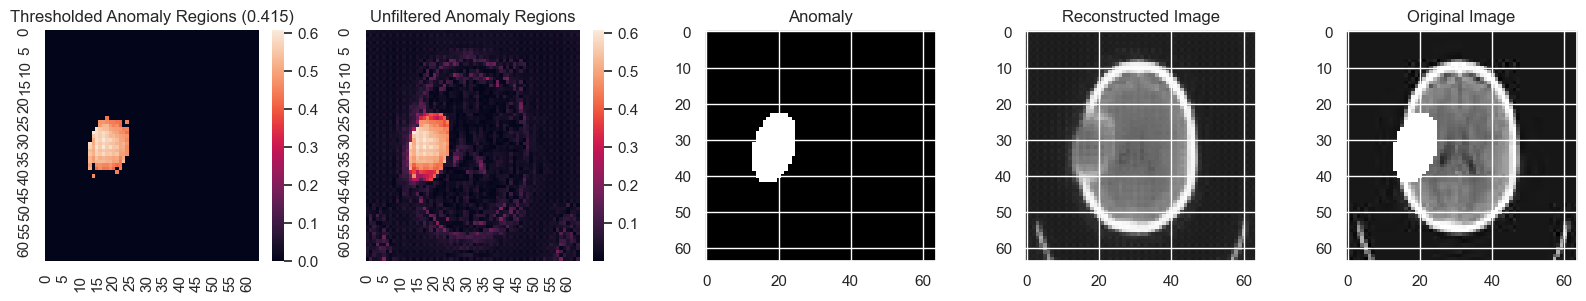

In [139]:
#supervised ve no bottleneck

look_num = 19 #49 #46 #1000 #1 #304
plt.subplots(1,5, figsize=(20, 3))
plt.subplot(1,5,1)
threshed = np.copy(y_stat[look_num][0])
thresh = 0.4150
threshed[threshed < thresh] = 0
sns.heatmap(threshed, annot=False)
plt.title(f"Thresholded Anomaly Regions ({thresh})")
plt.subplot(1,5,2)
sns.heatmap(y_stat[look_num][0], annot=False)
plt.title("Unfiltered Anomaly Regions")
plt.subplot(1,5,3)
plt.imshow(y_mask_np[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Anomaly")
plt.subplot(1,5,4)
plt.imshow(y_pred[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,5)
plt.imshow(y_true[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

Text(0.5, 1.0, 'Original Image')

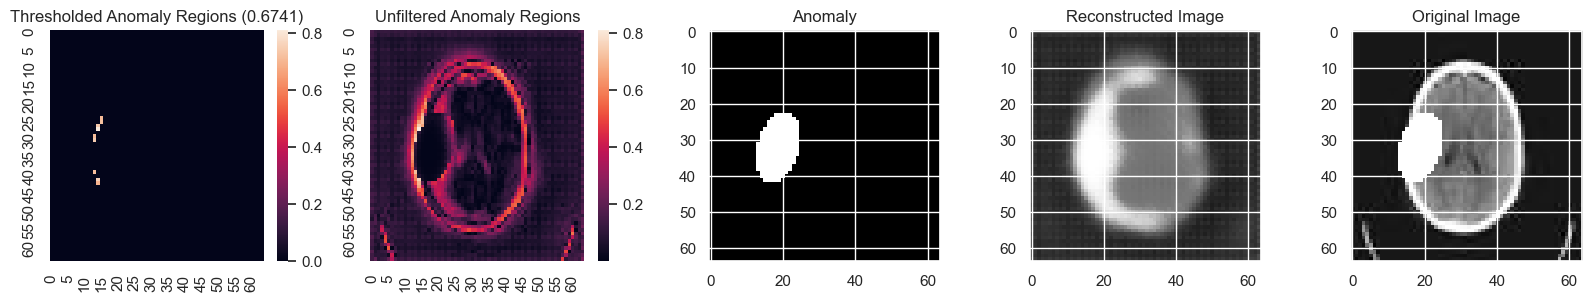

In [240]:
#new unsupervised ae

look_num = 19 #49 #46 #1000 #1 #304
plt.subplots(1,5, figsize=(20, 3))
plt.subplot(1,5,1)
threshed = np.copy(y_stat[look_num][0])
thresh = 0.67410
threshed[threshed < thresh] = 0
sns.heatmap(threshed, annot=False)
plt.title(f"Thresholded Anomaly Regions ({thresh})")
plt.subplot(1,5,2)
sns.heatmap(y_stat[look_num][0], annot=False)
plt.title("Unfiltered Anomaly Regions")
plt.subplot(1,5,3)
plt.imshow(y_mask_np[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Anomaly")
plt.subplot(1,5,4)
plt.imshow(y_pred[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,5)
plt.imshow(y_true[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

Text(0.5, 1.0, 'Original Image')

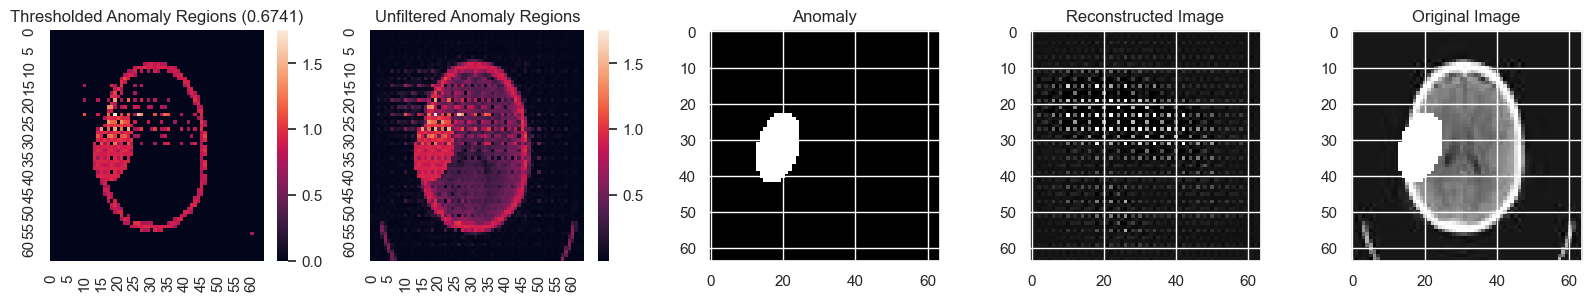

In [113]:
#this is the supervised autoencoder

look_num = 19 #49 #46 #1000 #1 #304
plt.subplots(1,5, figsize=(20, 3))
plt.subplot(1,5,1)
threshed = np.copy(y_stat[look_num][0])
thresh = 0.67410
threshed[threshed < thresh] = 0
sns.heatmap(threshed, annot=False)
plt.title(f"Thresholded Anomaly Regions ({thresh})")
plt.subplot(1,5,2)
sns.heatmap(y_stat[look_num][0], annot=False)
plt.title("Unfiltered Anomaly Regions")
plt.subplot(1,5,3)
plt.imshow(y_mask_np[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Anomaly")
plt.subplot(1,5,4)
plt.imshow(y_pred[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,5)
plt.imshow(y_true[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

Text(0.5, 1.0, 'Original Image')

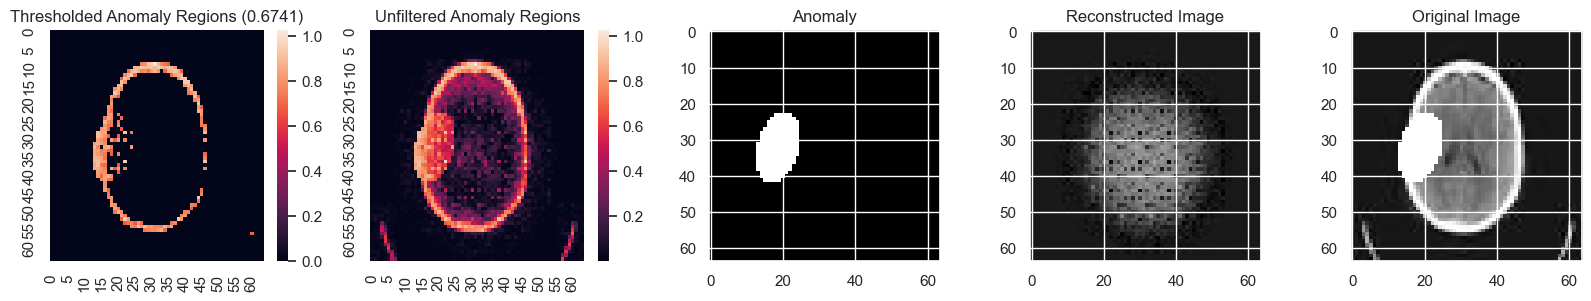

In [56]:
#This is the unsupervised autoencoder

look_num = 19 #49 #46 #1000 #1 #304
plt.subplots(1,5, figsize=(20, 3))
plt.subplot(1,5,1)
threshed = np.copy(y_stat[look_num][0])
thresh = 0.67410
threshed[threshed < thresh] = 0
sns.heatmap(threshed, annot=False)
plt.title(f"Thresholded Anomaly Regions ({thresh})")
plt.subplot(1,5,2)
sns.heatmap(y_stat[look_num][0], annot=False)
plt.title("Unfiltered Anomaly Regions")
plt.subplot(1,5,3)
plt.imshow(y_mask_np[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Anomaly")
plt.subplot(1,5,4)
plt.imshow(y_pred[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,5)
plt.imshow(y_true[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

Text(0.5, 1.0, 'Original Image')

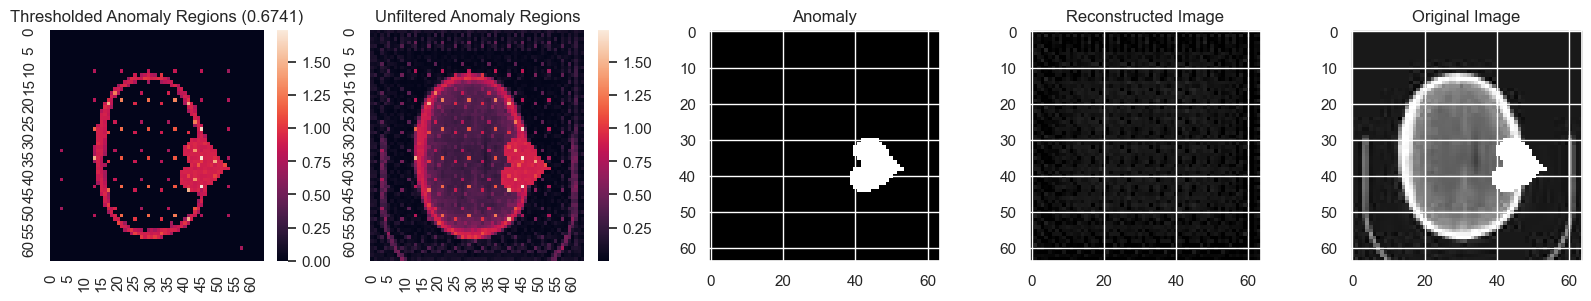

In [48]:
#this is unsupervised VAE

look_num =  #49 #46 #1000 #1 #304
plt.subplots(1,5, figsize=(20, 3))
plt.subplot(1,5,1)
threshed = np.copy(y_stat[look_num][0])
thresh = 0.67410
threshed[threshed < thresh] = 0
sns.heatmap(threshed, annot=False)
plt.title(f"Thresholded Anomaly Regions ({thresh})")
plt.subplot(1,5,2)
sns.heatmap(y_stat[look_num][0], annot=False)
plt.title("Unfiltered Anomaly Regions")
plt.subplot(1,5,3)
plt.imshow(y_mask_np[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Anomaly")
plt.subplot(1,5,4)
plt.imshow(y_pred[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,5)
plt.imshow(y_true[look_num][0].cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

Text(0.5, 1.0, 'Original Image')

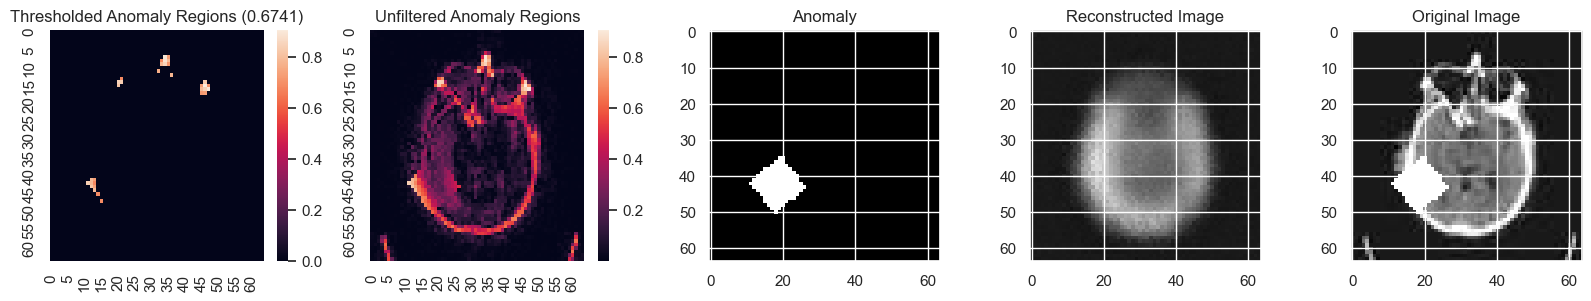

In [105]:
#y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
#prior_quantile = np.quantile(y_true_np, 0.9)
#print("Prior quantile:",prior_quantile)
#y_stat_test = np.copy(y_stat)
#y_stat_test[y_stat_test < prior_quantile] = 0

look_num = 234 #49 #46 #1000 #1 #304
plt.subplots(1,5, figsize=(20, 3))
plt.subplot(1,5,1)
threshed = np.copy(y_stat[look_num][0])
thresh = 0.67410
threshed[threshed < thresh] = 0
sns.heatmap(threshed, annot=False)
plt.title(f"Thresholded Anomaly Regions ({thresh})")
plt.subplot(1,5,2)
sns.heatmap(y_stat[look_num][0], annot=False)
plt.title("Unfiltered Anomaly Regions")
plt.subplot(1,5,3)
plt.imshow(y_mask_np[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Anomaly")
plt.subplot(1,5,4)
plt.imshow(y_pred[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Reconstructed Image")
plt.subplot(1,5,5)
plt.imshow(y_true[look_num][0], cmap="gray", vmin=0, vmax=1)
plt.title("Original Image")

In [106]:
_fpr, _tpr, _ = roc_curve(y_true[look_num][0],y_pred[look_num][0])
roc_auc = auc(_fpr, _tpr)

ValueError: continuous-multioutput format is not supported